In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.signal import welch
from nsdmd import utils
from nsdmd import nsdmd

In [12]:
freqs_true = np.arange(2,100,5)
t_step = 0.001
t = np.arange(5000)
max_amp = 1
power = -2.

nets = []
phi_as = []
phi_ps = []
freq_amps = []
F_trues = []
for f in freqs_true:
    phi_a = np.random.rand(100) + 0.5
    phi_a = phi_a / np.sum(phi_a**2, axis=0)**0.5
    phi_p = np.random.randint(-50,50,size=100)
    freq_amp = np.ones(len(t)) * max_amp * f**power
    net, F_true, _ = utils.make_network(f, len(t), phi_a, phi_p, time_mod=freq_amp)
    nets.append(net)
    phi_as.append(phi_a)
    phi_ps.append(phi_p)
    freq_amps.append(freq_amp)
    F_trues.append(F_true)
nets = np.array(nets)
phi_as = np.array(phi_as)
phi_ps = np.array(phi_ps)
freq_amps = np.array(freq_amps)
F_trues = np.array(F_trues)

x = np.sum(nets, axis=0)
x = utils.add_noise(x, std=0.003, freq_scaling=-2.5)
t = np.arange(x.shape[1]) * t_step
t = t - t[1500]

Text(0, 0.5, 'Channel')

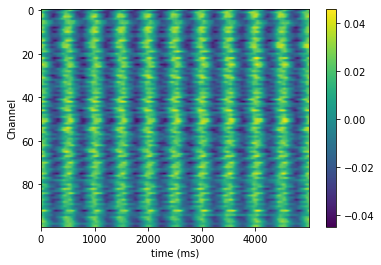

In [13]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0.5, 1.0, 'Channel 1 PSD')

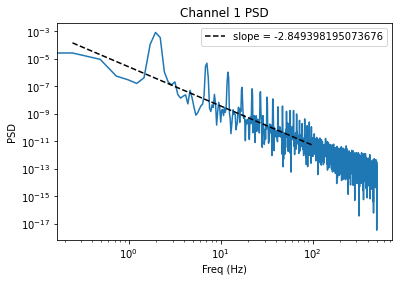

In [14]:
psd_f, psd_p = welch(x[0], fs=int(1/t_step), nperseg = 4096)
psd_ff = psd_f.copy()[psd_f<=100][1:]
psd_pp = psd_p.copy()[psd_f<=100][1:]
slope, intercept, _, _, _ = scipy.stats.linregress(np.log(psd_ff), np.log(psd_pp))
plt.loglog(psd_f, psd_p)
plt.plot(psd_ff, np.exp(intercept)*(psd_ff**slope), color='black', linestyle='dashed', \
         label='slope = '+str(slope))
# plt.loglog(freqs_true, freq_amps[:,0])
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')
plt.title('Channel 1 PSD')

In [15]:
model = nsdmd.NSDMD(opt_rank=4, opt_stride=100, sim_thresh_phi_amp=0.92, verbose=True, bandpass_trim=1500)

In [16]:
bp_ranges = [[i,i+5] for i in np.arange(1,100,5)]
model.fit_opt(x, t, t_step, bandpass=bp_ranges)
x = x[:,1500:-1500]
t = t[1500:-1500]

[1 6]
[ 6 11]
[11 16]
[16 21]
[21 26]
[26 31]
[31 36]
[36 41]
[41 46]
[46 51]
[51 56]
[56 61]
[61 66]
[66 71]
[71 76]
[76 81]
[81 86]
[86 91]
[91 96]
[ 96 101]


Text(0.5, 1.0, 'Similar Solutions')

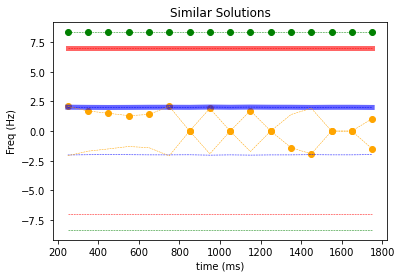

In [17]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx))[:8]:
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [18]:
idx_init = nsdmd.get_red_init(group_idx, len(model.windows_))
idx_init = idx_init[~np.all(model.freqs_[tuple(np.transpose(idx_init, [1,0,2]))]==0, axis=1)]
soln, _, _ = nsdmd.get_soln(model.freqs_, model.phis_, idx_init, len(t), model.windows_, model.drift_N, t_step)

In [19]:
soln.shape

(175, 100, 2000)

In [28]:
def reduction_grad(soln, x, alpha, beta, N, lr, maxiter, fit_coupling, delay, verbose=True):
    idx_all = []

    f_hat = nsdmd.grad_f(x, soln, alpha, beta, N, lr, maxiter, fit_coupling, delay)
    f_hat = nsdmd.grad_f_amp(f_hat, soln, x)
    x_rec = nsdmd.get_reconstruction(soln, f_hat)
    total_error = [nsdmd.get_reconstruction_error(x, x_rec)]

    for i in range(f_hat.shape[0]):
        if verbose:
            print(str(i) + '/' + str(f_hat.shape[0]))
        if i==0:
            idx = np.arange(f_hat.shape[0])
        else:
            idx = idx[np.arange(len(idx))!=np.argmax(error)]
        idx_all.append(idx)

        if(len(idx)>1):
            error = np.empty(len(idx))
            for j, r in enumerate(idx):
                idx_sub = idx[idx!=r]
                soln_sub = soln[idx_sub]
                f_hat = nsdmd.grad_f(x, soln_sub, alpha, beta, N, lr, maxiter, fit_coupling, delay)
                f_hat = nsdmd.grad_f_amp(f_hat, soln_sub, x)
                x_rec = nsdmd.get_reconstruction(soln_sub, f_hat)
                error[j] = nsdmd.get_reconstruction_error(x, x_rec)
            total_error.append(np.max(error))
    return(idx_all, total_error)

In [29]:
test = reduction_grad(soln, x, model.grad_alpha, model.grad_beta, \
                      model.grad_N, model.grad_lr, 3, model.grad_fit_coupling, None)

0/175


KeyboardInterrupt: 

In [8]:
model.fit_reduction(x, len(t), t_step)

In [9]:
plt.plot(model.errors_)
plt.axvline(0)
plt.xlabel('Num Modes Removed')
plt.ylabel('Cosine Distance')

AttributeError: 'NSDMD' object has no attribute 'errors_'

In [11]:
model.fit_f(x, len(t), t_step, 1)

/tmp/ipykernel_2537/2092082735.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


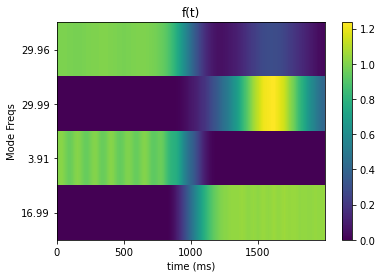

In [12]:
alpha = [str(np.round(f,2)) for f in model.freq_mean_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

Text(0.5, 1.0, 'f(t) vs True f(t)')

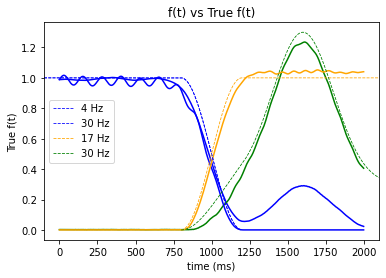

In [13]:
colors = ['blue', 'green', 'blue', 'orange', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,500:-500]):
    plt.plot(f, color=colors[i])

plt.plot(t1-500, np.mean(F1_true, axis=0), color=colors[2], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
plt.plot(t2-500, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
plt.plot(t3-500, np.mean(F3_true, axis=0), color=colors[3], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
plt.plot(t4-500, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
plt.legend()
plt.xlim(-100,2100)
plt.xlabel('time (ms)')
plt.ylabel('True f(t)')
plt.title('f(t) vs True f(t)')

In [14]:
x_rec = model.transform(x, len(t), t_step)

Text(0, 0.5, 'Channel')

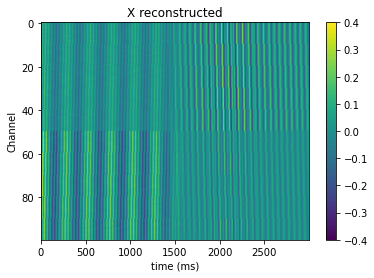

In [15]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

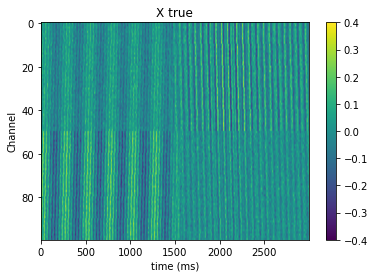

In [16]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')